In [1]:
import numpy as np
import pandas as pd

names = ['Ball-X','Ball-Y','Velocity-X','Velocity-Y','Paddle-Y','Action']
expert = pd.read_csv('expert_policy.txt', sep=" ", names=names)
expert.head()

,Ball-X,Ball-Y,Velocity-X,Velocity-Y,Paddle-Y,Action
0,0.50,0.50,0.03,0.01,0.40,2.0
1,0.53,0.51,0.03,0.01,0.44,2.0
2,0.56,0.52,0.03,0.01,0.48,2.0
3,0.59,0.53,0.03,0.01,0.52,0.0
4,0.62,0.54,0.03,0.01,0.48,2.0


In [2]:
x = expert.iloc[:,0:5]
x.head()

,Ball-X,Ball-Y,Velocity-X,Velocity-Y,Paddle-Y
0,0.50,0.50,0.03,0.01,0.40
1,0.53,0.51,0.03,0.01,0.44
2,0.56,0.52,0.03,0.01,0.48
3,0.59,0.53,0.03,0.01,0.52
4,0.62,0.54,0.03,0.01,0.48


In [3]:
y = expert.iloc[:,5:6]
y.head()

,Action
0,2.0
1,2.0
2,2.0
3,0.0
4,2.0


In [52]:
### Credit to Siping Meng from his Part 1 work
import numpy as np
import math
import random
import pprint
import sys
import matplotlib.pyplot as plt
#===========CHANGABLE PARAMETERS=================
REWARD     = 1
PENALTY    = -1
DISCOUNT   = 0.8
LEARN_RATE_CONST = 200

def get_explore_rate(epoch):
    return max(0.1,1-math.log2(epoch*10)/20)

#===========DEFINE CONSTANTS AND DICS=============
WALL_LEN = 1
PADDLE_H = 0.2

init_state = (0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2)

ACTION_DIC={0:-0.04, #'UP'
            1:0,     #'STAY'
            2:0.04}  #'DOWN'

BOARD_SIZE = 12
X_VBALL_DIS = [-1,1]
Y_VBALL_DIS = [-1,0,1]

PADDLE_SPACE = 12
PADDLE_X     = 1

STATE_SPACE = (BOARD_SIZE,BOARD_SIZE,len(X_VBALL_DIS),len(Y_VBALL_DIS),PADDLE_SPACE)

X_V_TSH = 0.03
Y_V_TSH = 0.015

#==============DEFINE STATE CLASS===============
class state:
    
    def __init__(self,ball_x,ball_y,velocity_x,velocity_y,paddle_y,reward,end_state = 0):
        self.ball_x = ball_x              #real numbers on the interval [0,1]
        self.ball_y = ball_y
        self.velocity_x = velocity_x
        self.velocity_y = velocity_y
        self.paddle_y = paddle_y
        self.reward = reward
        self.state_tuple = (ball_x,ball_y,velocity_x,velocity_y,paddle_y)
        self.end_state = end_state
        self._extract()
        
    def _extract(self):
        self.x_grid = min(math.floor(12*self.ball_x),BOARD_SIZE-1)
        self.y_grid = min(math.floor(12*self.ball_y),BOARD_SIZE-1)
        if(self.velocity_x>0): 
            self.x_v_sign = 0
        else: 
            self.x_v_sign = 1
            
        if(self.velocity_y>=0.015):
            self.y_v_sign = 0
        elif(self.velocity_y<=0.015): 
            self.y_v_sign = 1
        else:
            self.y_v_sign = 2
        self.paddle_grid = min(math.floor(12 * self.paddle_y / (1 - PADDLE_H)),PADDLE_SPACE-1)
        self.space_tuple = (self.x_grid,self.y_grid,self.x_v_sign,self.y_v_sign,self.paddle_grid)
        
#=============DEFINE Q-AGENT CLASS==============
class q_agent:
    
    def __init__(self,mode = 'new',learning = 'Q'):
        if mode == 'new':
            print('successfully generate a new Q-Agent!')
            self.q_table = np.zeros(STATE_SPACE+(len(ACTION_DIC),)) 
            self.table_vis = np.zeros(STATE_SPACE+(len(ACTION_DIC),))
            self.end_state = 0
        elif mode == 'load':
            print('loading past data...')
            if learning == 'Q':
                self.q_table = np.load('qtable.npy')
                self.table_vis = np.load('tablevis.npy')
            elif learning == 'SARSA':
                self.q_table = np.load('qtable_sa.npy')
                self.table_vis = np.load('tablevis_sa.npy')
            else:
                print('wrong learning method!')
                sys.exit()
            print('successfully load data')
        else:
            print('cannot read the mode, exit')
            sys.exit()
        
    def set_table(self,loc,val):
        self.q_table[loc] = val
    
    def get_table(self,loc):
        return self.q_table[loc]

    def get_c(self,loc):
        return self.table_vis[loc]
    
    def set_c(self,loc,val):
        self.table_vis[loc] = val
        
    def get_act(self,cur_state,i,mode = 'train',learning='Q'):
        if mode=='train' and random.random()<get_explore_rate(i):
            return random.choice(range(0,3,1))
        return np.argmax(self.get_table(cur_state.space_tuple))
    

#=======DEFINE MORE HELPER FUNCTIONS===========
def bounce(cur_state,action,mode = 'Part1.1'):
    n_ball_v_x = cur_state.velocity_x
    n_ball_v_y = cur_state.velocity_y

    n_ball_x = cur_state.ball_x + n_ball_v_x
    n_ball_y = cur_state.ball_y + n_ball_v_y

    fac = n_ball_v_y*(1-cur_state.ball_x)/n_ball_v_x #for 1.1
    cmp_y = cur_state.ball_y + fac
    
    fac_2 = n_ball_v_y*(cur_state.ball_x)/n_ball_v_x
    cmp_y_2 = cur_state.ball_y + fac_2
    #======paddle should in range(0,0.8)=====
    n_paddle_y = min(WALL_LEN-PADDLE_H,max(0,cur_state.paddle_y + action))
    
    c_reward = 0
    
    #==the ball is off the top of the screen==
    if n_ball_y < 0:
        n_ball_y = -n_ball_y
        n_ball_v_y = -n_ball_v_y
        
    #==the ball is off the bottom of the screen==
    if n_ball_y > 1:
        n_ball_y = 2*WALL_LEN-n_ball_y
        n_ball_v_y = -n_ball_v_y
    
    #==the ball is off the left edge of the screen== ###PART1.1
    if n_ball_x < 0 and mode == 'Part1.1':
        n_ball_x = -n_ball_x
        n_ball_v_x = -n_ball_v_x
    #== the ball bouncing off the paddle==
    if n_ball_x >= 1 and mode == 'Part1.1' and (n_paddle_y+PADDLE_H >= min(max(0,cmp_y),1) >= n_paddle_y):
        n_ball_x = 2*PADDLE_X - n_ball_x
        n_ball_v_x, n_ball_v_y = update_speed_rand(n_ball_v_x,n_ball_v_y)
        c_reward = REWARD
    elif n_ball_x > 1 and mode == 'Part1.1':
        c_reward = PENALTY
    
    #==the ball is off the left edge of the screen== ###PART1.2
    if n_ball_x > 1 and mode == 'Part1.2':
        n_ball_x = 2*WALL_LEN - n_ball_x
        n_ball_v_x = -n_ball_v_x
    #== the ball bouncing off the paddle==
    if n_ball_x <= 0 and mode == 'Part1.2' and (n_paddle_y+PADDLE_H >= min(max(0,cmp_y_2),1) >= n_paddle_y):
        n_ball_x = - n_ball_x
        n_ball_v_x, n_ball_v_y = update_speed_rand(n_ball_v_x,n_ball_v_y)
        c_reward = REWARD
    elif n_ball_x < 0 and mode == 'Part1.2':
        c_reward = PENALTY
   

    return n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward

def update_speed_rand(velocity_x,velocity_y):
    vx_delta = random.choice(range(-1,2,2)) * random.choice(range(0,16,1)) / 1000
    vy_delta = random.choice(range(-1,2,2)) * random.choice(range(0,4,1))  / 100
    sign_x = -velocity_x/abs(velocity_x)
    sign_y = velocity_y/abs(velocity_y)
    n_ball_v_x = sign_x*max(X_V_TSH,min(1,abs(vx_delta+velocity_x)))
    n_ball_v_y = sign_y*max(Y_V_TSH,min(1,abs(vy_delta+velocity_y)))
    return n_ball_v_x, n_ball_v_y

def proceed_one_step(cur_state,action,mode = 'Part1.1'):

    n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward = bounce(cur_state,action,mode)
    end = 0
    if c_reward == -1:
        end = 1
    n_state = state(n_ball_x,n_ball_y,n_ball_v_x,n_ball_v_y,n_paddle_y,c_reward,end_state=end)
    return n_state

#=============DEFINE TRAIN FUCNTION=============
def train(epoch_num,q_ag,mode = 'Part1.1',learning = 'Q'):
    graph = [0]
    pre_tot = 0
    tot_bounce = 0
    for i in range(1,epoch_num+1):
        temp_bounce = 0
        
        if mode == 'Part1.1':
            cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        elif mode == 'Part1.2':
            cur_state = state(0.5, 0.5, -0.03, 0.01, 0.5 - PADDLE_H / 2,0)
        sarsa_act = q_ag.get_act(cur_state,i)
        while True:

            if learning == 'Q':
                
                action = q_ag.get_act(cur_state,i)
                n_state = proceed_one_step(cur_state,ACTION_DIC[action],mode)
                old_val = q_ag.get_table(cur_state.space_tuple+(action,))


                prd_max = np.max(q_ag.get_table(n_state.space_tuple))
                prd_tuple = (n_state.x_grid,n_state.y_grid,n_state.x_v_sign,n_state.y_v_sign,n_state.paddle_grid,prd_max)

                Nsa = q_ag.get_c(cur_state.space_tuple+(action,))
                learn_rate = LEARN_RATE_CONST/(LEARN_RATE_CONST+Nsa)
                q_ag.set_c(cur_state.space_tuple+(action,),Nsa+1)

                new_val = (1-learn_rate)*old_val + learn_rate*(n_state.reward + DISCOUNT*prd_max)
                q_ag.set_table(cur_state.space_tuple+(action,),new_val)

                
                
            elif learning == 'SARSA':
                
                n_state = proceed_one_step(cur_state,ACTION_DIC[sarsa_act],mode)
                
                n_sarsa_act = q_ag.get_act(n_state,i)
                
                old_val = q_ag.get_table(cur_state.space_tuple+(sarsa_act,))


                prd_max = q_ag.get_table(n_state.space_tuple+(n_sarsa_act,))
#                 prd_tuple = (n_state.x_grid,n_state.y_grid,n_state.x_v_sign,n_state.y_v_sign,n_state.paddle_grid,prd_max)

                Nsa = q_ag.get_c(cur_state.space_tuple+(sarsa_act,))
                learn_rate = LEARN_RATE_CONST/(LEARN_RATE_CONST+Nsa)
                q_ag.set_c(cur_state.space_tuple+(sarsa_act,),Nsa+1)

                new_val = (1-learn_rate)*old_val + learn_rate*(n_state.reward + DISCOUNT*prd_max)
                q_ag.set_table(cur_state.space_tuple+(sarsa_act,),new_val)
                sarsa_act = n_sarsa_act
                
            else: 
                print('Wrong learning input!')
                sys.exit()    
                
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
        if i%1000 == 0:
            print('loop',i)
            print('now average bounce in this 1000 round is', (tot_bounce-pre_tot)/1000)
            print('bounce=',tot_bounce-pre_tot)
            print()
            graph.append(tot_bounce/i)
            pre_tot = tot_bounce
    return graph
#================DEFINE TEST FUNCTION============
def test2(epoch_num,mlp):
    tot_bounce = 0
    for i in range(epoch_num):
        temp_bounce = 0
        cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
            
        while True:
            action = mlp.predict([list(cur_state.state_tuple)])[0]
            n_state = proceed_one_step(cur_state,ACTION_DIC[action])
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
    
    print('the avg bounce =',tot_bounce/epoch_num)

def test3(epoch_num,mlp):
    tot_bounce = 0
    for i in range(epoch_num):
        temp_bounce = 0
        cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
            
        while True:
            action = mlp.predict(scaler.transform([np.asarray(list(cur_state.state_tuple))]))[0]
            n_state = proceed_one_step(cur_state,ACTION_DIC[action])
            if n_state.end_state == 1:
                break
            if n_state.reward == REWARD:
                temp_bounce+=1
            cur_state = n_state
        tot_bounce+=temp_bounce
    
    print('the avg bounce =',tot_bounce/epoch_num)

In [5]:
import warnings
from sklearn.neural_network import MLPClassifier
warnings.filterwarnings('ignore')
n = 1
acc = []
while n < 150:
    mlp = MLPClassifier(hidden_layer_sizes=(256,256,256),max_iter=n,learning_rate_init=0.001,shuffle=True,batch_size=100,tol=-0.5,early_stopping=True)
    mlp.fit(x, y.values.ravel())
    acc.append(mlp.score(x,y))
    n += 1
print(acc)

[0.5447, 0.6396, 0.7033, 0.7331, 0.7387, 0.7154, 0.7584, 0.7665, 0.7892, 0.8088, 0.8065, 0.8, 0.8113, 0.8206, 0.8152, 0.8377, 0.8517, 0.8416, 0.8446, 0.8527, 0.8425, 0.8577, 0.8673, 0.8669, 0.8503, 0.8726, 0.8669, 0.863, 0.8763, 0.8778, 0.8679, 0.8877, 0.8846, 0.8723, 0.8774, 0.8864, 0.8787, 0.8836, 0.8761, 0.8825, 0.8867, 0.897, 0.8965, 0.8854, 0.882, 0.8888, 0.8875, 0.8966, 0.8958, 0.8961, 0.8989, 0.9006, 0.9018, 0.9, 0.8961, 0.9047, 0.8847, 0.9074, 0.9026, 0.9134, 0.9141, 0.9092, 0.9049, 0.9095, 0.9097, 0.9137, 0.9157, 0.8956, 0.9069, 0.9036, 0.9075, 0.9036, 0.9014, 0.9158, 0.9034, 0.9152, 0.906, 0.9192, 0.9171, 0.9168, 0.917, 0.9164, 0.9149, 0.916, 0.9125, 0.9133, 0.9123, 0.9254, 0.9156, 0.9172, 0.9139, 0.9156, 0.9204, 0.9104, 0.9162, 0.917, 0.9131, 0.9222, 0.9259, 0.9201, 0.9205, 0.9271, 0.9282, 0.9164, 0.9201, 0.9231, 0.9205, 0.938, 0.9266, 0.9244, 0.9292, 0.9067, 0.9195, 0.9252, 0.9092, 0.915, 0.9117, 0.9283, 0.9291, 0.929, 0.926, 0.9303, 0.932, 0.927, 0.9257, 0.9367, 0.933, 0.9

In [16]:
mlp = MLPClassifier(hidden_layer_sizes=(256,256,256),max_iter=150,learning_rate_init=0.001,shuffle=True,batch_size=100,tol=-0.5,early_stopping=True)
mlp.fit(x, y.values.ravel())
acc.append(mlp.score(x,y))

In [17]:
print("Number of Training Epochs: {}".format(len(mlp.loss_curve_)))

Number of Training Epochs: 150


In [18]:
### Confusion Matrix and Classification Error
from sklearn.metrics import classification_report, confusion_matrix
predictions = mlp.predict(x)
print(confusion_matrix(y,predictions))
print("Classification Accuracy: {}".format(mlp.score(x,y)))

[[2984  154  196]
 [  41 2239   63]
 [  81  129 4113]]
Classification Accuracy: 0.9336


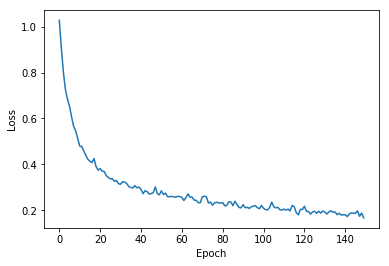

In [19]:
### Loss vs. Epoch plot
import matplotlib.pyplot as plt
plt.plot(mlp.loss_curve_)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

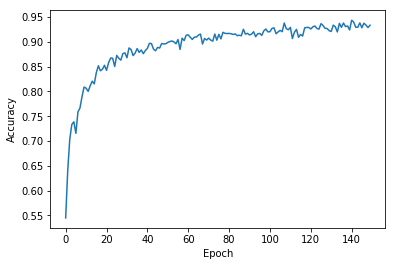

In [20]:
### Accuracy vs. Epoch plot
plt.plot(acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [54]:
### Number of Bounces
cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
test2(5000,mlp)

the avg bounce = 8.151


In [27]:
### Batch Normalization
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(x)
x_norm = scaler.transform(x)
print(x_norm)

mlp2 = MLPClassifier(hidden_layer_sizes=(256,256,256),max_iter=150,learning_rate_init=0.001,shuffle=True,batch_size=100,tol=-0.5,early_stopping=True)
mlp2.fit(x_norm, y.values.ravel())
mlp2.score(x_norm,y)

[[-0.01708048 -0.05516055  0.6377731   0.32748549 -0.45141093]
 [ 0.08689763 -0.01934015  0.6377731   0.32748549 -0.26815638]
 [ 0.19087574  0.01648025  0.6377731   0.32748549 -0.08490183]
 ...
 [-0.25623014 -1.18350314 -0.82983063  1.87246097  0.28160727]
 [-0.38793575 -0.97932686 -0.82983063  1.87246097  0.46486182]
 [-0.51617542 -0.77515058 -0.82983063  1.87246097  0.28160727]]


0.9534

In [55]:
### Number of Bounces
print("With batch normalization,")
cur_state = state(0.5, 0.5, 0.03, 0.01, 0.5 - PADDLE_H / 2,0)
test3(5000,mlp2)

With batch normalization,
the avg bounce = 7.9174
